# Paired positive selection primers

The purpose of this notebook is to generate a list of paired primers that include random mutations at positively selected sites in spike. Double-mutant primers are generated only for those sites that are close to each other.

In [ ]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
import Bio
from Bio.Seq import Seq
import statistics
from plotnine import *

In [ ]:
#snakmake input
reference_lookup = snakemake.input.reference_lookup
positive_sel_df = snakemake.input.positive_sel_df
spike_extended = snakemake.input.spike_extended

positiveSelection_paired_primers_out = snakemake.output.positiveSelection_paired_primers_out

In [ ]:
reference_lookup = pd.read_csv(reference_lookup)
positive_sel_df = pd.read_csv(positive_sel_df)

In [3]:
#import reference sequence
spike_ref = next(SeqIO.parse(spike_extended, 'fasta'))

In [4]:
#get number of nuclotides that are outside coding region and convert to the number of added amino acids
upperseq = ''.join([nt for nt in spike_ref.seq if nt.istitle()])
lower_5_prime = spike_ref.seq.index(upperseq)/3
lower_5_prime

11.0

In [5]:
#merge lookup and positive selection site tables
#remove mutations that are in variant spike already
new_positive_sel_df = pd.merge(positive_sel_df,
                  reference_lookup,
                  how='left',
                  left_on=['site'],
                  right_on = ['parent_pos'],
                  indicator=True)


In [6]:
#now merge tables just on parent position
new_positive_sel_df = pd.merge(positive_sel_df,
                  reference_lookup,
                  how='left',
                  left_on=['site'],
                  right_on = ['parent_pos'])

new_positive_sel_df = new_positive_sel_df.sort_values(by=['site'],ignore_index=True)
#drop missing sites, this removes +ve selection sites that are in CTD or in missing positions in the variant
new_positive_sel_df = new_positive_sel_df[new_positive_sel_df['variant_pos'].notna()]
new_positive_sel_df = new_positive_sel_df[['variant_pos','variant_seq','n_time_windows', 'p']]
new_positive_sel_df

,variant_pos,variant_seq,n_time_windows,p
0,5.0,L,16,0.002201
1,12.0,S,5,0.006430
2,13.0,S,8,0.008677
3,18.0,L,13,0.007383
4,19.0,R,6,0.005278
...,...,...,...,...
75,1174.0,V,14,0.009348
76,1189.0,K,8,0.005793
77,1217.0,G,12,0.007598
78,1226.0,V,4,0.006887


In [7]:
new_positive_sel_df['variant_pos_plus_5pr'] = new_positive_sel_df['variant_pos']+lower_5_prime
PS_sites = new_positive_sel_df['variant_pos_plus_5pr'].tolist()

In [8]:
def ReverseComplement(seq):
    """Returns reverse complement of sequence. Preserves upper/lower case."""
    d = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'a': 't', 't': 'a', 'c': 'g',
         'g': 'c', 'N':'N'}
    rc = [d[nt] for nt in seq]
    rc.reverse()
    return ''.join(rc)

Loop through every defined positive selection site and generate a primer sequence that includes that site at the extreme 5' or 3' end of the primer. Primer length is adjusted to fall in the target Tm. Then add the primer name and sequence to a list. We get a list with primers for each of the positively selected sites. These entries are in the form (positively_selected_site, primer_seq).

In [9]:
def gen_edge_primers(wt_nts, epitopes):
    
    # default primer settings
    primerlength = 37
    maxprimertm = 64
    minprimertm = 64
    minlength = 30
    maxlength = 51
    
    wt_aa = wt_nts.seq.translate()
    ncodons = len(wt_aa)
    
    # flank length is the number of nucleotides between the end of the primer and
    # the first site to mutate
    flank_length = 8
    fiveprime_epitope_primers = []
    threeprime_epitope_primers = []
    for icodon in range(ncodons):
        if icodon + 1 in epitopes:

            # add a primer where the epitope is one codon away from the 5' end
            five_prime_start = ((icodon+1) * 3) - 3 - flank_length # returns 0-indexed starting *nt* posn of primer
            primer = wt_nts.seq[five_prime_start : five_prime_start + primerlength]

            new_primerlength = primerlength
            TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))

            # shorten primer if Tm is too high
            if float(TmNN) > float(maxprimertm):
                while (float(TmNN) > float(maxprimertm) and len(primer) > minlength):
                    # only change length from 3' end
                    new_primerlength -= 1
                    primer = wt_nts.seq[five_prime_start : five_prime_start + new_primerlength]

                    # update Tm
                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            # lengthen primer if Tm is too low
            elif float(TmNN) < float(minprimertm):
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    new_primerlength += 1
                    primer = wt_nts.seq[five_prime_start : five_prime_start + new_primerlength]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            else:
                pass

            fiveprime_epitope_primers.append((icodon+1, str(primer)))

            # and repeat to add a primer where the epitope is one codon away from the 3' end

            three_prime_end = ((icodon+1) * 3) + flank_length # returns 0-indexed ending *nt* posn of primer
            primer = wt_nts.seq[three_prime_end - primerlength + 1 : three_prime_end + 1]

            new_primerlength = primerlength
            TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            if float(TmNN) > float(maxprimertm):
                while (float(TmNN) > float(maxprimertm) and len(primer) > minlength):
                    # only change length from 5' end
                    new_primerlength -= 1
                    primer = wt_nts.seq[three_prime_end - new_primerlength + 1 : three_prime_end + 1]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            elif float(TmNN) < float(minprimertm):
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    new_primerlength += 1
                    primer = wt_nts.seq[three_prime_end - new_primerlength + 1 : three_prime_end + 1]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            else:
                pass

            threeprime_epitope_primers.append((icodon+1, str(primer)))
    
    primer_lists = [fiveprime_epitope_primers, threeprime_epitope_primers]
    return primer_lists

In [10]:
PS_primers = gen_edge_primers(spike_ref, PS_sites)

Next, we can take the length for each primer, and ask whether any other epitopes are within that range. If there are, group them as a pair, and output an evenly centered primer within the length / Tm range specified above. The epitopes of interest will be replaced with NNG or NNC.

In [12]:
def gen_paired_epitope_primers(wt_nts, edge_primers, epitopes, name_prefix, 
                               random_codon_fwd_1, random_codon_fwd_2, outfile):
    
    # default primer settings
    primerlength = 37
    maxprimertm = 64
    minprimertm = 64
    minlength = 30
    maxlength = 51
    
    fiveprime_epitope_primers = edge_primers[0]
    threeprime_epitope_primers = edge_primers[1]
    
    paired_epitopes = []
    paired_epitope_primers = []
    
    flank_length = 8

    for primer in fiveprime_epitope_primers:
        # convert primer length into codon position range
        epitope_1 = primer[0]
        primer_seq = primer[1]
        primer_nt_start = (epitope_1 * 3) - 2 - flank_length
        primer_nt_end = primer_nt_start + len(primer_seq) - 1

        # for each entry, query whether any of the other epitopes are in that range
        for epitope_2 in epitopes:

            if primer_nt_start < ((epitope_2*3)-2-flank_length) and primer_nt_end > ((epitope_2 * 3)+flank_length):
                
                # track which pairs we've already found
                paired_epitopes.append((epitope_1, epitope_2)) 
                # pull minimal sequence that's inclusive of the paired epitopes
                epitopes_start = (epitope_1 * 3) - 2
                epitopes_end = int(epitope_2 * 3)
                min_primer = wt_nts.seq[epitopes_start : epitopes_end+1]
                TmNN = ('%0.2f' % mt.Tm_NN(min_primer, strict=False))

                # lengthen primer on both sides until Tm is correct
                minus_5 = True
                flank5 = flank3 = flank_length
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    if minus_5:
                        flank5 += 1
                        paired_primer = wt_nts.seq[epitopes_start - flank5 : epitopes_end + flank3 + 1]
                        primer_name = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}'
                        minus_5 = False
                    else:
                        flank3 += 1
                        paired_primer = wt_nts.seq[epitopes_start - flank5 : epitopes_end + flank3 + 1]
                        primer_name = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}'
                        minus_5 = True
                    TmNN = ('%0.2f' % mt.Tm_NN(paired_primer, strict=False))

                # change epitope sites to random codon by adding up seq strings based on flank lengths from previous step
                # there's probably a better way to do this
                fwd_paired_primer = str(paired_primer)
                
                primer_name1 = f'{name_prefix}-for-mut_epi-{epitope_1-lower_5_prime}-{epitope_2-lower_5_prime}_{random_codon_fwd_1}'
                random_fwd_primer1 = fwd_paired_primer[:flank5-1]+random_codon_fwd_1+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_1+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name2 = f'{name_prefix}-for-mut_epi-{epitope_1-lower_5_prime}-{epitope_2-lower_5_prime}_{random_codon_fwd_2}'
                random_fwd_primer2 = fwd_paired_primer[:flank5-1]+random_codon_fwd_2+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_2+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name3 = f'{name_prefix}-for-mut_epi-{epitope_1-lower_5_prime}-{epitope_2-lower_5_prime}_{random_codon_fwd_1}_{random_codon_fwd_2}'
                random_fwd_primer3 = fwd_paired_primer[:flank5-1]+random_codon_fwd_1+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_2+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name4 = f'{name_prefix}-for-mut_epi-{epitope_1-lower_5_prime}-{epitope_2-lower_5_prime}_{random_codon_fwd_2}_{random_codon_fwd_1}'
                random_fwd_primer4 = fwd_paired_primer[:flank5-1]+random_codon_fwd_2+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_1+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                fwd_random_primers = [(primer_name1, random_fwd_primer1), (primer_name2, random_fwd_primer2), 
                                      (primer_name3, random_fwd_primer3), (primer_name4, random_fwd_primer4)]
                
                # get reverse complement and add both to primer list
                for fwd_primer in fwd_random_primers:
                    rev_primer_name = fwd_primer[0].replace('for', 'rev')
                    rev_primer = ReverseComplement(fwd_primer[1])
                    paired_epitope_primers.append(fwd_primer)
                    paired_epitope_primers.append((rev_primer_name, rev_primer))
    
    # now check whether there's any additional pairs in threeprime_epitope_primers
    for primer in threeprime_epitope_primers:
        # convert primer length into codon position range
        epitope_2 = primer[0]
        primer_seq = primer[1]
        primer_nt_end = (epitope_2 * 3) + flank_length
        primer_nt_start = primer_nt_end - len(primer_seq) + 1

        # for each entry, query whether any of the other epitopes are in that range
        for epitope_1 in epitopes:
            if primer_nt_start < ((epitope_1*3)-2-flank_length) and primer_nt_end > ((epitope_1 * 3)+flank_length):
                if (epitope_1, epitope_2) not in paired_epitopes:
                    print(paired_epitopes)
                    # Just throw an error if something's missing
                    # everything should be covered by the fiveprime edge primers
                    raise ValueError(f'missing pair: {epitope_1}_{epitope_2}')
                    
    # sort primer list to get fwd and rev pools together
    paired_epitope_primers_sorted = sorted(paired_epitope_primers, key = lambda x: x[0])
    
    f = open(outfile, 'w')
    for (name, primer) in paired_epitope_primers_sorted:
        f.write(f'{name}, {primer}\r\n')
    
    return paired_epitope_primers_sorted

In [13]:
#save paired primers
PS_paired_primers = gen_paired_epitope_primers(spike_ref, PS_primers, 
                                                 PS_sites, 'delta_PS_paired', 'NNG', 'NNC',
                                                 positiveSelection_paired_primers_out)

## Check primer Tm distribution

In [14]:
names = ['Pool name','Sequence']
PS_paired_primers = pd.read_csv(positiveSelection_paired_primers_out, names = names)
PS_paired_primers

,Pool name,Sequence
0,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNC,CCACAGATTATCACCNNCNNCAACACCTTTGTGTCTGG
1,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNC_NNG,CCACAGATTATCACCNNCNNGAACACCTTTGTGTCTGG
2,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNG,CCACAGATTATCACCNNGNNGAACACCTTTGTGTCTGG
3,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNG_NNC,CCACAGATTATCACCNNGNNCAACACCTTTGTGTCTGG
4,delta_PS_paired-for-mut_epi-12.0-13.0_NNC,GCCACTGGTGNNCNNCCAGTGTGTGAA
...,...,...
235,delta_PS_paired-rev-mut_epi-934.0-937.0_NNG_NNC,GGCTGTGCTGNNCAGGGACNNCTGAATCT
236,delta_PS_paired-rev-mut_epi-95.0-98.0_NNC,CCTGATGATGTTGNNCTTCTCGNNGCTGGCAAAG
237,delta_PS_paired-rev-mut_epi-95.0-98.0_NNC_NNG,CCTGATGATGTTCNNCTTCTCGNNGCTGGCAAAG
238,delta_PS_paired-rev-mut_epi-95.0-98.0_NNG,CCTGATGATGTTCNNCTTCTCCNNGCTGGCAAAG


In [15]:
PS_paired_primers['Tm'] = PS_paired_primers.apply(lambda x: '%0.2f' % mt.Tm_NN(x.Sequence, strict=False), axis=1)
PS_paired_primers['Tm'] = PS_paired_primers['Tm'].astype('float')
PS_paired_primers['length'] = PS_paired_primers.apply(lambda x: len(x.Sequence), axis=1)
PS_paired_primers

,Pool name,Sequence,Tm,length
0,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNC,CCACAGATTATCACCNNCNNCAACACCTTTGTGTCTGG,63.61,39
1,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNC_NNG,CCACAGATTATCACCNNCNNGAACACCTTTGTGTCTGG,63.62,39
2,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNG,CCACAGATTATCACCNNGNNGAACACCTTTGTGTCTGG,63.62,39
3,delta_PS_paired-for-mut_epi-1115.0-1116.0_NNG_NNC,CCACAGATTATCACCNNGNNCAACACCTTTGTGTCTGG,64.14,39
4,delta_PS_paired-for-mut_epi-12.0-13.0_NNC,GCCACTGGTGNNCNNCCAGTGTGTGAA,61.64,28
...,...,...,...,...
235,delta_PS_paired-rev-mut_epi-934.0-937.0_NNG_NNC,GGCTGTGCTGNNCAGGGACNNCTGAATCT,62.67,30
236,delta_PS_paired-rev-mut_epi-95.0-98.0_NNC,CCTGATGATGTTGNNCTTCTCGNNGCTGGCAAAG,63.52,35
237,delta_PS_paired-rev-mut_epi-95.0-98.0_NNC_NNG,CCTGATGATGTTCNNCTTCTCGNNGCTGGCAAAG,62.94,35
238,delta_PS_paired-rev-mut_epi-95.0-98.0_NNG,CCTGATGATGTTCNNCTTCTCCNNGCTGGCAAAG,62.94,35


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


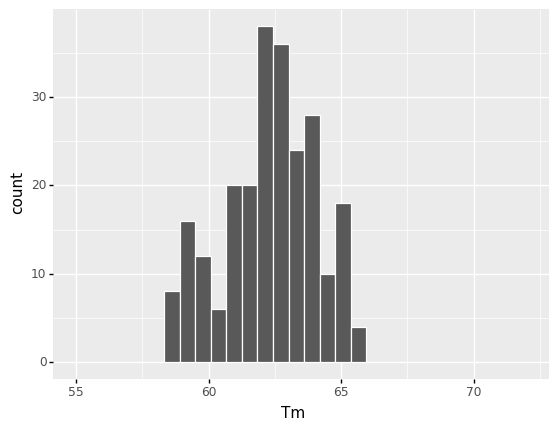

<bound method ggplot.draw of <ggplot: (8770530451297)>>

In [16]:
p = (ggplot(PS_paired_primers) + 
     aes('Tm') + 
     geom_histogram(color='white', bins=30)+
     xlim(55,72)
    )

p.draw

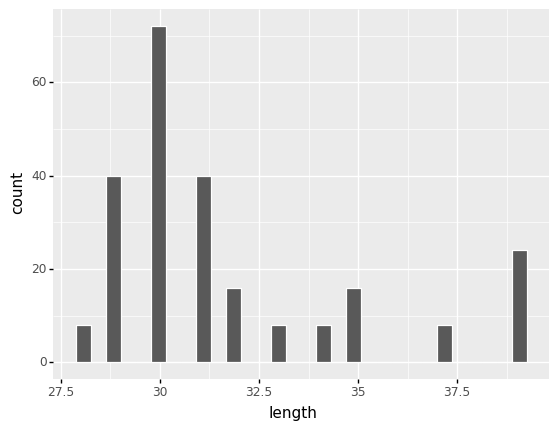

<bound method ggplot.draw of <ggplot: (8770530416954)>>

In [17]:
p = (ggplot(PS_paired_primers) + 
     aes('length') + 
     geom_histogram(color='white',bins=30)
    )

p.draw

In [18]:
statistics.pvariance(PS_paired_primers['Tm'])

3.118518826388889